## Importing Libraries

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading the dataset

In [96]:
dataset = pd.read_csv("CO2 Emissions_Canada.csv")

## Data cleaning and engeenering

In [97]:
non_informative_columns = ["Make", "Model"]
redundant_columns = ["Fuel Consumption Comb (L/100 km)", "Fuel Consumption Comb (mpg)"]
columns_to_drop = non_informative_columns + redundant_columns
dataset.drop(columns=columns_to_drop, inplace=True)
dataset.isna().sum()

Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
CO2 Emissions(g/km)                 0
dtype: int64

## Features and Target division

In [98]:
y = dataset["CO2 Emissions(g/km)"]
X = dataset.drop("CO2 Emissions(g/km)", axis=1)

## Transforming categorical data into numerical columns

In [99]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(
    transformers=[("encoder", OneHotEncoder(drop='first'), ["Vehicle Class", "Transmission", "Fuel Type"])], remainder="passthrough"
)
X = ct.fit_transform(X).toarray()



## Splitting the data into Train and Test sets

In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=22)

## Features Scaling

In [101]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Selecting an Optimal Regression Model

In [102]:
import concurrent.futures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

models_to_run = []

for degree in range(1, 3):
    models_to_run.append(('poly_' + str(degree), LinearRegression(), PolynomialFeatures(degree)))

regressionModels = [SVR(), DecisionTreeRegressor(), RandomForestRegressor()]
for model in regressionModels:
    models_to_run.append((model.__class__.__name__, model, None))

results = []

def train_model(name, model, poly):
    if poly:
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.transform(X_test)
        model.fit(X_poly_train, y_train)
        return (name, model, X_poly_test, poly)
    else:
        model.fit(X_train, y_train)
        return (name, model, X_test, None)

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(train_model, name, model, poly) for name, model, poly in models_to_run]
    for f in concurrent.futures.as_completed(futures):
        results.append(f.result())

regressions = results

## Evaluating $ \mathbb{R}^ 2 $ score

In [130]:
from sklearn.metrics import r2_score, mean_squared_error

top_model = ('', None, None, 0, 0)
model_names = []
r2_scores = []
mse_scores = []

for name, reg, X_test, poly in regressions:
    y_pred = reg.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"The {name} model has an R^2 score of {r2:.5f} and MSE of {mse:.5f}")
    if r2 > top_model[3]:
        top_model = (name, reg, poly, r2, mse)
    model_names.append(name)
    r2_scores.append(r2)
    mse_scores.append(mse)

The DecisionTreeRegressor model has an R^2 score of 0.99456 and MSE of 18.56874
The poly_1 model has an R^2 score of 0.99145 and MSE of 29.17236
The SVR model has an R^2 score of 0.82539 and MSE of 595.49304
The poly_2 model has an R^2 score of 0.99738 and MSE of 8.94740
The RandomForestRegressor model has an R^2 score of 0.99722 and MSE of 9.47706


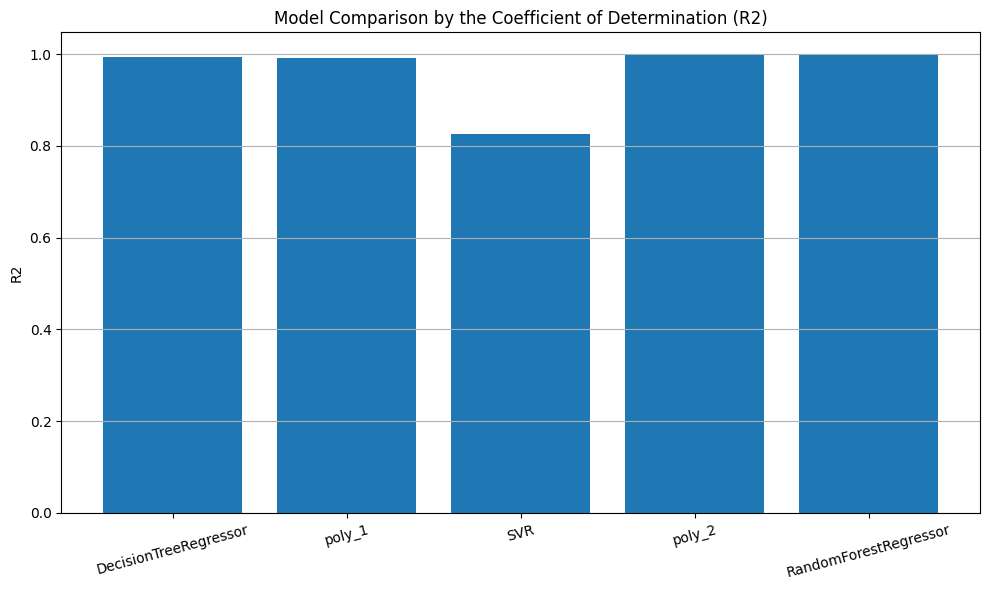

In [124]:
plt.figure(figsize=(10, 6))
plt.bar(model_names, r2_scores)
plt.title('Model Comparison by the Coefficient of Determination (R2)')
plt.ylabel('R2')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

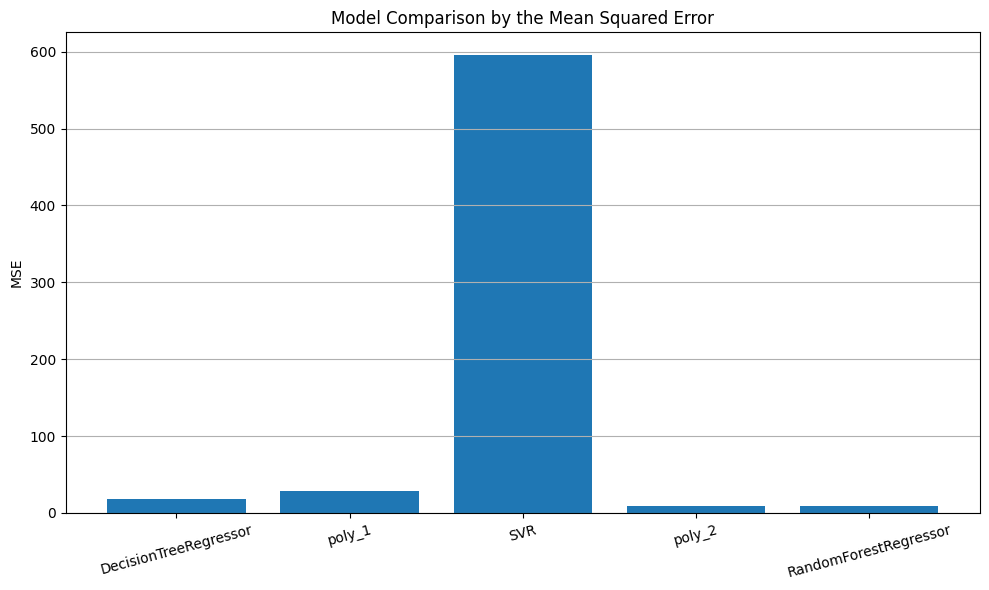

In [128]:
plt.figure(figsize=(10, 6))
plt.bar(model_names, mse_scores)
plt.title("Model Comparison by the Mean Squared Error")
plt.ylabel('MSE')
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Selecting the best One

In [131]:
print(
    f"\nThe top-performing model is {top_model[0]} with an R^2 score of {top_model[3]:.5f} and MSE of {top_model[4]:.5f}."
)


The top-performing model is poly_2 with an R^2 score of 0.99738 and MSE of 8.94740.


## Test Prediction for a Single Instance

In [105]:
vehicle_prototype_instance = pd.DataFrame([{
'Vehicle Class': "COMPACT",
'Engine Size(L)': 2,
'Cylinders': 4,
'Transmission': "AS5",
'Fuel Type': "Z",
'Fuel Consumption City (L/100 km)': 9.9,
'Fuel Consumption Hwy (L/100 km)': 6.7
}])

In [109]:
new_X = vehicle_prototype_instance
new_X = ct.transform(new_X).toarray()
new_X = sc.transform(new_X)
new_X_poly_2 = top_model[2].transform(new_X)

regression = top_model[1]
co2_emission_pred = regression.predict(new_X_poly_2)[0]

In [110]:
print(f"For a vehicle with characteristics:")
for key, val in vehicle_prototype_instance.items():
    print(f"{key}: {val.iloc[0]}")
print(f"The predicted emissions of CO2 are: {co2_emission_pred} g/km")

For a vehicle with characteristics:
Vehicle Class: COMPACT
Engine Size(L): 2
Cylinders: 4
Transmission: AS5
Fuel Type: Z
Fuel Consumption City (L/100 km): 9.9
Fuel Consumption Hwy (L/100 km): 6.7
The predicted emissions of CO2 are: 193.1659226040564 g/km
